![](https://images.aicrowd.com/raw_images/challenges/banner_file/1021/bbbabcdf334159faa322.png)

<h2><center> Getting Started with Face Recognition Challenge</center></h2>

In this puzzle, we have identify the face from the given collage of faces. 

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be submitting the sample prediction directly in the required format.



 AIcrowd code utilities for downloading data for Language Classification


# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic


## Login to AIcrowd ㊗¶


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/-b9whrgT4qa2MHLtwou3gNx9QKUkHTQ1LzZdBARkAeA
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c face-recognition -o data

data.zip:   0%|          | 0.00/747M [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

In [ ]:
!unzip data/data.zip -d data > /dev/null

## Diving in the dataset 🕵️‍♂️

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
import cv2

random.seed(1000)

In [ ]:
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Diving in the dataset 🕵️‍♂️

In [ ]:
missing_image = 'data/missing'
colage_image = 'data/target'

# get the list of the image id
missing_pathlist = os.listdir(missing_image)
target_pathlist = os.listdir(colage_image)

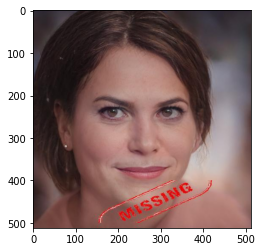

In [ ]:
# check out a sample missing file
sample_missing = os.path.join(missing_image, missing_pathlist[0])
sample_miss_img = cv2.imread(sample_missing)
sample_miss_img = cv2.cvtColor(sample_miss_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_miss_img)
plt.show()

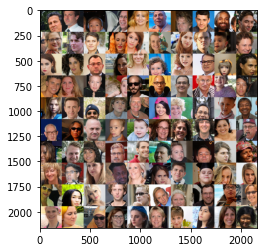

In [ ]:
# check out a sample target file
sample_img = cv2.imread(os.path.join(colage_image, target_pathlist[0]))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

In [ ]:
# check out the shape of target file to get each face grid size 
sample_img.shape

(2160, 2160, 3)

We can see that the size is `2160 * 2160` and 10 pictures in each row and each column, therefore the size of each small picture grid is `216 * 216`

In [ ]:
# get target face
def get_target_face(face_no, target_image):

  ''' This function helps to retrieve the individual faces from the main patch of 100 images'''
  x, y = face_no // 10, face_no % 10
  x, y = x *216, y *216

  target_face = target_image[x:x+216, y:y+216]
  # print(x, y)
  return target_face

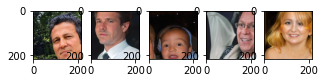

In [ ]:
# test the image
(fig, ax) = plt.subplots(1, 5, figsize=(5, 13)) 
for i in range(5):
  target_face = get_target_face(i, sample_img)
  ax[i].imshow(target_face)
plt.show()

# Model



## Use the [FaceNet Project](https://github.com/davidsandberg/facenet)

In [ ]:
!pip install cmake

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 32 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=f101ea7429a3e74db293728db4adb6fa0f1508a060bf1d8574a3b1668462be69
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import face_recognition

In [ ]:
# feed in the missing image
name = missing_pathlist[0]
unknown_path = os.path.join(missing_image, name)
# prepare the unknown encoding
unknown_image = face_recognition.load_image_file(unknown_path)
unknown_image = cv2.resize(unknown_image, (216,216))
unknown_encoding = face_recognition.face_encodings(unknown_image)

In [ ]:
match_target_total, unable_target, unable_miss = [], [], []

for name in tqdm(missing_pathlist):

  # feed in the missing image
  unknown_path = os.path.join(missing_image, name)
  # prepare the unknown encoding
  unknown_image = face_recognition.load_image_file(unknown_path)
  # reshape it as the same size of target
  unknown_image = cv2.resize(unknown_image, (216,216))
  unknown_encoding = face_recognition.face_encodings(unknown_image)


  # avoid this package unable to encode the missing
  if len(unknown_encoding) > 0:

    unknown_encoding = unknown_encoding[0]

    # prepare looping through all pictures grid in the targe
    target_match, unable = [], []
    target_img = cv2.imread(os.path.join(colage_image, name))

    # starting loop through all pic grid in target
    for i in range(100):

      # use the function design to get target grid
      temp = get_target_face(i, target_img)
      target_encoding = face_recognition.face_encodings(temp)

      # print('finish target_encoding')

      # avoid this package unable to encode the this target grid
      if len(target_encoding) > 0:
        result = face_recognition.compare_faces([target_encoding[0]], 
                                                unknown_encoding)
        # print('finish comparing {}'.format(i))

        # if the result is true (matched), attach the idx
        if result[0]:
          target_match.append(i)
          # print(target_match)
          break
      # also record the grid index that is unable to encode
      else:
        unable.append(i)
      

    # print('Finish comparing with all target')
    match_target_total.append(target_match)
    unable_target.append(unable)
    unable_miss.append(False)

  else:
    # if we are unable to encode the missing, skip to the next 
    match_target_total.append([])
    unable_target.append([])
    unable_miss.append(True)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# add all the result into dataframe
result_df = pd.DataFrame({'ImageID': missing_pathlist, 
                          'target_list': match_target_total,
                          'miss': unable_miss})
result_df['unable_target'] = unable_target

In [ ]:
# unlist the target id
result_df['target'] = result_df['target_list'].apply(pd.Series) \
  .stack().reset_index(level=1, drop=True)

In [ ]:
result_df.head()

,ImageID,target_list,miss,unable_target,target
0,a74x0.jpg,[29],False,[],29.0
1,rh6dw.jpg,[37],False,[],37.0
2,3whr1.jpg,[5],False,[],5.0
3,uprjf.jpg,[51],False,[13],51.0
4,sr232.jpg,[],False,[],NaN


In [ ]:
result_df.isna().sum()

ImageID            0
target_list        0
miss               0
unable_target      0
target           130
dtype: int64

## Rerun the model without resize for unmatched

In [ ]:
# filter out the unmatched
unmatched_id = result_df[(result_df['miss'] == True) | \
                         (result_df['target'].isna())]['ImageID']

In [ ]:
print('There are {} id out of 1000 are unmatched.'.format(len(unmatched_id)))

There are 130 id out of 1000 are unmatched.


In [ ]:
unmatched_result = {}
for um in tqdm(unmatched_id):

  um_result = []
  test = cv2.imread(os.path.join(missing_image, um))
  test = face_recognition.face_encodings(test)
  if len(test) > 0:
    unknown_encoding = test[0]
    target_img = cv2.imread(os.path.join(colage_image, um))

    # target_match = []
    for i in range(100):

      # use the function design to get target grid
      temp = get_target_face(i, target_img)
      target_encoding = face_recognition.face_encodings(temp)

      # avoid this package unable to encode the this target grid
      if len(target_encoding) > 0:
        result = face_recognition.compare_faces([target_encoding[0]], 
                                                unknown_encoding)

        # if the result is true (matched), attach the idx
        if result[0]:
          um_result.append(i)
          break
  unmatched_result[um] = um_result 

  0%|          | 0/130 [00:00<?, ?it/s]

In [ ]:
# filter out the matched
filtered_dict = {k:v for k,v in unmatched_result.items() if len(v) >0 }

# find out the id still unmatched
ummatched_id2 = [k for k,v in unmatched_result.items() if len(v) == 0]

In [ ]:
print('Without resizing, we matched {} out of 130.'.format(len(filtered_dict)))
print('Still, we cannot match {} out of 130.'.format(len(ummatched_id2)))

Without resizing, we matched 58 out of 130.
Still, we cannot match 72 out of 130.


## Use ORB to match the remaining

In [ ]:
orb = cv2.ORB_create()

In [ ]:
unmatched_result2 = {}
for um in tqdm(ummatched_id2):

  test = cv2.imread(os.path.join(missing_image, um))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = cv2.resize(test, (216,216))

  #keypoint and feature calculation to describe image
  kp, missing_des = orb.detectAndCompute(test, None) 

  target_img = cv2.imread(os.path.join(colage_image, um))

  # define the hypothetical best
  best_id = -99
  lowest = 99999999999999 #variable to store the least distance

  for i in range(100):

    # use the function design to get target grid
    temp = get_target_face(i, target_img)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    kp, target_des = orb.detectAndCompute(temp, None)

    try:
      # the brute force matcher
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
      # matches the features
      matches = bf.match(missing_des, target_des) 
      # sorting on distance
      matches = sorted(matches, key = lambda x:x.distance) 

      if (matches[0].distance + matches[1].distance 
          + matches[2].distance + matches[3].distance 
          + matches[4].distance + matches[5].distance) < lowest:
        lowest = matches[0].distance + matches[1].distance \
          + matches[2].distance + matches[3].distance \
          + matches[4].distance + matches[5].distance
        best_id = i
    except:
      pass

  unmatched_result2[um] = best_id

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
# we can see that all the remaining pictures get matched
[k for k,v in unmatched_result2.items() if v == -99]

[]

## Generating Prediction File

We here combine three results together and generate the file for submission.

In [ ]:
unmatch_result_total = {**filtered_dict, **unmatched_result2}

In [ ]:
result_df.head()

,ImageID,target_list,miss,target,unable_target
0,a74x0.jpg,[29],False,29.0,[]
1,rh6dw.jpg,[37],False,37.0,[]
2,3whr1.jpg,[5],False,5.0,[]
3,uprjf.jpg,[51],False,51.0,[13]
4,sr232.jpg,[],False,NaN,[]


In [ ]:
result_df_full = result_df.copy()
for id, target in unmatch_result_total.items():
  
  # get the index of the image id
  idx = result_df_full[result_df_full['ImageID'] == id].index.values[0]
  # add the keys to the dataframe for that index (id)
  result_df_full.iloc[idx, 4] = target

In [ ]:
# no missing for target now
result_df_full.isna().sum()

ImageID          0
target_list      0
miss             0
unable_target    0
target           0
dtype: int64

In [ ]:
# checkout the format for sample submission
sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub.head()

,ImageID,target
0,7xnxf,38
1,sixou,27
2,2wmyk,23
3,huj2b,96
4,67mx2,79


In [ ]:
submission = result_df_full[['ImageID', 'target']].copy()
submission['target'] = submission['target'].astype(int)
submission['ImageID'] = submission['ImageID'].str[:-4]

In [ ]:
submission.head()

,ImageID,target
0,a74x0,29
1,rh6dw,37
2,3whr1,5
3,uprjf,51
4,sr232,92


In [ ]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c face-recognition -a assets --no-verify

Using notebook: AI_Blix13_04_Face_Recognition_Challenge for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                   
                                                   │ Successfully submitted! │                                                   
                                                   ╰─────────────────────────╯

                                                         Important links                                                         
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-recognition/submissions/174789              │
│                  │                                                                                                            │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-recognition/submissions?my_submissions=true │
│                  │                                                                                                            │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-recognition/leaderboards                    │
│                  │                                                                                                            │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                              │
│                  │                                                                                                            │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-recognition                                 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────┘